In [2]:
import numpy as np
from copy import copy
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
from qiskit import ClassicalRegister
from qiskit_aer import QasmSimulator
import time

from simulated_annealing import simulated_annealing_func
from PTC_utils import PTC_pairs, decode_parity, qaoa_PTC
from SWAP_utils import SWAP_pairs, qaoa_SWAP, qubit_order
from utils import cost_maxcut, total_cnots_depth, WMaxCut, qaoa, objective_MaxCut, mitigate, random_samples

backend = QasmSimulator()


# PTC transpilation strategy

In [13]:
seed = 1
nq = 120

graphs = np.load(f"./Data/problems_transpilers_{seed}.npy", allow_pickle=True).item()
probs = graphs["probs"]
Ed = probs[nq][0]
G = graphs["G"][nq][Ed]
print("Edge density:", Ed)
list_2q = PTC_pairs(nq)
best_map = dict(zip(range(nq),range(nq)))
callback = {"cost": [], "depth": [], "iterations": [], "T": [], "cost_cache": {}}
best_cost = 0
for i in range(5):
    print(f"---------    iteration {i+1} ----------")
    best_map, current_cost, _ = simulated_annealing_func(G, best_map, list_2q, callback, initial_temp=0.01, cooling_rate=0.999, stop_temp=1e-8, max_iter=10000, verbose=True)
    if current_cost < best_cost:
        best_cost = current_cost
    else:
        break



Edge density: 0.034
---------    iteration 1 ----------
best depth:0 | best cost:-115 | iteration:1 | T:0.0100
best depth:0 | best cost:-116 | iteration:3 | T:0.0100
best depth:0 | best cost:-117 | iteration:30 | T:0.0097
best depth:0 | best cost:-118 | iteration:56 | T:0.0095
best depth:-1 | best cost:-234 | iteration:70 | T:0.0093
best depth:-1 | best cost:-235 | iteration:72 | T:0.0093
best depth:-1 | best cost:-236 | iteration:76 | T:0.0093
best depth:-2 | best cost:-351 | iteration:136 | T:0.0087
best depth:-2 | best cost:-352 | iteration:143 | T:0.0087
best depth:-2 | best cost:-353 | iteration:144 | T:0.0087
best depth:-2 | best cost:-354 | iteration:148 | T:0.0086
best depth:-3 | best cost:-472 | iteration:149 | T:0.0086
best depth:-4 | best cost:-586 | iteration:153 | T:0.0086
best depth:-4 | best cost:-587 | iteration:159 | T:0.0085
best depth:-4 | best cost:-588 | iteration:167 | T:0.0085
best depth:-4 | best cost:-589 | iteration:187 | T:0.0083
best depth:-4 | best cost:-59

# PTC circuit creation using the SA information

In [14]:
mapping = {v: k for k, v in best_map.items()}
G_shuffled = nx.relabel_nodes(G.copy(), mapping)
cost, depth = total_cnots_depth(G_shuffled, list_2q)
list_used = copy(list_2q[:nq+depth])
qord = reversed(range(nq))
p = 1
delta_beta = 0.5
delta_gamma = 0.5
betas = np.arange(1,p+1)[::-1] * (delta_beta / p)
gammas = np.arange(1,p+1) * (delta_gamma / p)
qc = qaoa_PTC(gammas, betas, G_shuffled, list_used)
qc.add_register(ClassicalRegister(nq))
qc.measure(qord, range(nq))
# qc = transpile(qc, backends["ibm_brisbane"])

if nq < 20:
    shots = 1000
    dict_results = backend.run(qc, shots=shots).result().get_counts()
    samples = {decode_parity(k, p, list_used):c for k, c in dict_results.items()}    
    samples = {"".join(k[mapping[i]] for i in range(nq)):v for k, v in samples.items()}
    cost = defaultdict(int)
    for k, v in samples.items():
        cost[cost_maxcut(k, G)] += v
    cost
    print(samples)
print("Operations:", qc.count_ops(), "depth:", qc.depth())

Operations: OrderedDict([('cx', 7852), ('rz', 243), ('h', 120), ('rx', 120), ('measure', 120)]) depth: 155


Text(0, 0.5, 'depth reduction')

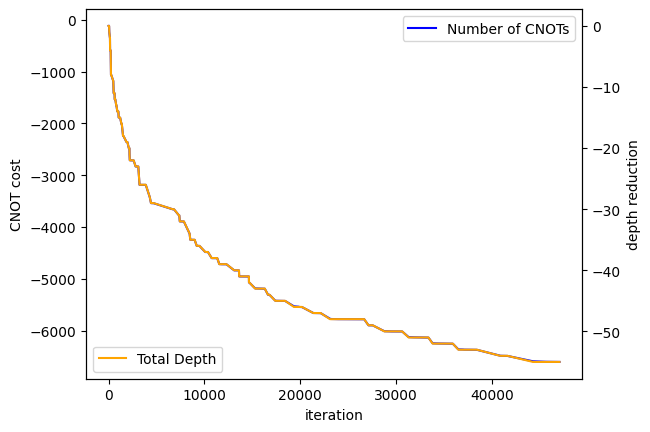

In [15]:
fig, ax = plt.subplots()
ax.plot(callback["iterations"], callback["cost"], label="Number of CNOTs", color='blue')
ax2 = ax.twinx()
ax2.plot(callback["iterations"], callback["depth"], label="Total Depth", color='orange')
ax.legend()
ax2.legend(loc=3)
ax.set_xlabel("iteration")
ax.set_ylabel("CNOT cost")
ax2.set_ylabel("depth reduction")


# SWAP Networks encoding using the SA reduction

In [6]:
seed = 1
# 3 regular graph
nq = 10
G = nx.random_regular_graph(3, nq, seed=123)
for i, j in G.edges():
    G[i][j]["weight"] = 1
mdl = WMaxCut(G)
mdl.solve()
sol = "".join(str(round(mdl.solution.get_value(var))) for var in mdl.iter_binary_vars())
print("optimal solution:", sol)
list_2q = SWAP_pairs(nq)
best_map = dict(zip(range(nq), range(nq)))
callback = defaultdict(list)
best_cost = 0
for i in range(20):
    print(f"---------    iteration {i+1} ----------")
    best_map, current_cost, info_sa = simulated_annealing_func(G, best_map, list_2q, callback, initial_temp=0.01, cooling_rate=0.9999, stop_temp=1e-8, max_iter=10000, verbose=True)
    G_shuffled = nx.relabel_nodes(G.copy(), best_map)
    if current_cost < best_cost:
        best_cost = current_cost
    else:
        break
    
    

optimal solution: 1110011000
---------    iteration 1 ----------
best depth:0 | best cost:-2 | iteration:1 | T:0.0100
best depth:0 | best cost:-3 | iteration:2 | T:0.0100
best depth:-1 | best cost:-7 | iteration:3 | T:0.0100
best depth:-1 | best cost:-8 | iteration:12 | T:0.0100
best depth:-2 | best cost:-11 | iteration:25 | T:0.0100
best depth:-2 | best cost:-12 | iteration:34 | T:0.0100
best depth:-3 | best cost:-16 | iteration:44 | T:0.0100
best depth:-3 | best cost:-17 | iteration:108 | T:0.0099
best depth:-4 | best cost:-18 | iteration:378 | T:0.0096
best depth:-4 | best cost:-19 | iteration:396 | T:0.0096
---------    iteration 2 ----------


In [8]:
mapping = {v: k for k, v in best_map.items()}
G_shuffled = nx.relabel_nodes(G.copy(), mapping)
cost, depth = total_cnots_depth(G_shuffled, list_2q)
list_used = copy(list_2q[:nq+depth])

p = 100
delta_beta = 0.6
delta_gamma = 0.7
betas = np.arange(1,p+1)[::-1] * (delta_beta / p)
gammas = np.arange(1,p+1) * (delta_gamma / p)
q_order = list(range(nq))
qc = qaoa_SWAP(gammas, betas, G_shuffled, list_used)
qc.add_register(ClassicalRegister(nq))
qc.measure(reversed(range(nq)), range(nq))
if nq < 20:
    shots = 1000
    dict_results = backend.run(qc, shots=shots).result().get_counts()
    samples = {"".join(k[i] for i in (range(nq) if p%2==0 else np.argsort(qubit_order(nq, len(list_used)-1)))):c for k, c in dict_results.items()}    
    samples = {"".join(k[mapping[i]] for i in range(nq)):v for k, v in samples.items()}
    cost = defaultdict(int)
    for k, v in samples.items():
        cost[cost_maxcut(k, G)] += v
    print("Samples:", samples)
print("Operations:", qc.count_ops(), "depth:", qc.depth())

Samples: {'0101011110': 1, '1010000101': 1, '1110011000': 495, '0001100111': 503}
Operations: OrderedDict([('cx', 5400), ('rx', 1000), ('rz', 900), ('rzz', 600), ('h', 10), ('measure', 10)]) depth: 1802


Text(0, 0.5, 'depth reduction')

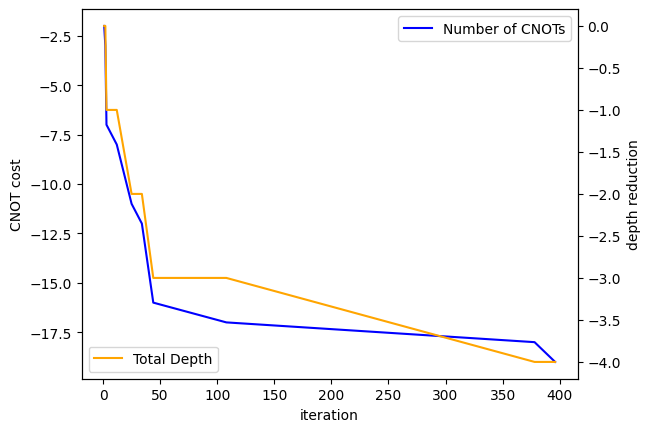

In [16]:
fig, ax = plt.subplots()
ax.plot(info_sa["iterations"], info_sa["cost"], label="Number of CNOTs", color='blue')
ax2 = ax.twinx()
ax2.plot(info_sa["iterations"], info_sa["depth"], label="Total Depth", color='orange')
ax.legend()
ax2.legend(loc=3)
ax.set_xlabel("iteration")
ax.set_ylabel("CNOT cost")
ax2.set_ylabel("depth reduction")


# Running all the paper experiments.

In [11]:
seed = 1
nq = 100
nqs = [20,30,40,50,60,70,80,90,100,110,120]
nqs = [20]
seeds = [1]
methods = {"PTC": qaoa_PTC, "SWAP": qaoa_SWAP}
list_2q_method = {"PTC": PTC_pairs, "SWAP": SWAP_pairs}
max_sa_iter = 5
max_iter = 10000
for seed in seeds:
    print("\n ++++++++++++++++++++++++++++ seed:", seed, "++++++++++++++++++++++++++++ \n")
    graphs = np.load(f"./Data/problems_transpilers_{seed}.npy", allow_pickle=True).item()
    for nq in nqs:
        print("++++++++++++++++++++++++++++ nq:", nq, "++++++++++++++++++++++++++++")
        probs = graphs["probs"][nq]
        operations = np.load(f"./Data/{nq}_transpiler_{seed}.npy", allow_pickle=True).item()
        for Ed in probs:
            print("Edge density:", Ed)
            G = graphs["G"][nq][Ed]
            for method_name, function in methods.items():
                print("Method:", method_name)
                list_2q = list_2q_method[method_name](nq)
                best_map = dict(zip(range(nq), range(nq)))
                callback = defaultdict(list)
                best_cost = 0
                ti = time.time()
                for iter in range(max_sa_iter):
                    print(f"---------    iteration {iter+1} ----------")
                    best_map, current_cost, info_sa = simulated_annealing_func(G.copy(), best_map, list_2q, callback, initial_temp=0.01, cooling_rate=0.999, stop_temp=1e-8, max_iter=max_iter, verbose=False)
                    if current_cost < best_cost:
                        best_cost = current_cost
                    else:
                        break
                
                mapping = {v: k for k, v in best_map.items()}
                G_shuffled = nx.relabel_nodes(G.copy(), mapping)
                cost, depth = total_cnots_depth(G_shuffled, list_2q)
                list_used = copy(list_2q[:nq+depth])
                qord = reversed(range(nq))
                p = 1
                delta_beta = 0.6
                delta_gamma = 0.7
                betas = np.arange(1,p+1)[::-1] * (delta_beta / p)
                gammas = np.arange(1,p+1) * (delta_gamma / p)
                qc = function(gammas, betas, G_shuffled, list_used)
                qc.add_register(ClassicalRegister(nq))
                qc.measure(qord, range(nq))
                tf = time.time()
                print("Operations:", qc.count_ops(), "depth:", qc.depth())

                operations[method_name][Ed] = qc.count_ops()
                operations[method_name][Ed]["time"] = tf - ti
                operations[method_name][Ed]["depth"] = qc.depth()
                operations[method_name][Ed]["SA_map"] = best_map
                operations[method_name][Ed]["SA_cost"] = best_cost
                operations[method_name][Ed]["SA_depth"] = depth
                operations[method_name][Ed]["SA_info"] = info_sa

            np.save(f"./Data/{nq}_transpiler_{seed}.npy", operations)


 ++++++++++++++++++++++++++++ seed: 1 ++++++++++++++++++++++++++++ 

++++++++++++++++++++++++++++ nq: 20 ++++++++++++++++++++++++++++
Edge density: 0.211
Method: PTC
---------    iteration 1 ----------
---------    iteration 2 ----------
Operations: OrderedDict([('cx', 264), ('rz', 41), ('h', 20), ('rx', 20), ('measure', 20)]) depth: 41
Method: SWAP
---------    iteration 1 ----------
---------    iteration 2 ----------
Operations: OrderedDict([('cx', 312), ('rz', 35), ('h', 20), ('rx', 20), ('measure', 20), ('rzz', 6)]) depth: 44
Edge density: 0.298
Method: PTC
---------    iteration 1 ----------
---------    iteration 2 ----------
Operations: OrderedDict([('cx', 321), ('rz', 57), ('h', 20), ('rx', 20), ('measure', 20)]) depth: 51
Method: SWAP
---------    iteration 1 ----------
---------    iteration 2 ----------
Operations: OrderedDict([('cx', 369), ('rz', 48), ('h', 20), ('rx', 20), ('measure', 20), ('rzz', 9)]) depth: 53
Edge density: 0.386
Method: PTC
---------    iteration 1 --